# Cylindrical compressive test

In [1]:
from ibvpy.bcond import BCSlice
from ibvpy.fets import FETS3D8H
from ibvpy.tmodel.mats3D import MATS3DElastic
from bmcs_matmod.ms1.ms1 import MS13D
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from mayavi import mlab
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid

import numpy as np


In [2]:
from bmcs_expsim.utils.mlab_decorators import decorate_figure

unit_length = 1
unit_height = 1

**Check the material parameters** of C40 concrete matrix

In [3]:
mp_db.C40MS1

{'E': 37000.0,
 'nu': 0.2,
 'Ad': 800.0,
 'eps_0': 7e-05,
 'K_N': 14000.0,
 'sigma_N_0': 25.0,
 'gamma_N': 5000.0,
 'sigma_T_0': 2.2,
 'K_T': 1200.0,
 'gamma_T': 65000,
 'S_T': 0.0025,
 'c_T': 8.7,
 'r_T': 9.2,
 'm_T': 0.001,
 'p_T': 7.5}

In [4]:
xmodel = XDomainFEGrid(coord_min=(0,0,0),
                     coord_max=(unit_height,unit_length, unit_length),
                     shape=(1, 1, 1),
                     integ_factor=1,
                     fets=FETS3D8H())

In [18]:
#tmodel = MS13D(**mp_db.C40MS1)
tmodel = MATS3DElastic(E=1, nu=0.2)

In [19]:
tmodel.D_abef

array([[[[1.11111111, 0.        , 0.        ],
         [0.        , 0.27777778, 0.        ],
         [0.        , 0.        , 0.27777778]],

        [[0.        , 0.41666667, 0.        ],
         [0.41666667, 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.41666667],
         [0.        , 0.        , 0.        ],
         [0.41666667, 0.        , 0.        ]]],


       [[[0.        , 0.41666667, 0.        ],
         [0.41666667, 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.27777778, 0.        , 0.        ],
         [0.        , 1.11111111, 0.        ],
         [0.        , 0.        , 0.27777778]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.41666667],
         [0.        , 0.41666667, 0.        ]]],


       [[[0.        , 0.        , 0.41666667],
         [0.        , 0.        , 0.        ],
         [0.41666667, 0.        , 0.        

In [ ]:
w_max = -1e-3
w_max = -1
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [13]:
m = TStepBC(
    domains=[(xmodel, tmodel)],
    bc=[bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0] # , bc_r_y],
)

m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
    # 'stress': Vis3DTensorField(var='sig_ab'),
    #        'damage': Vis3DStateField(var='omega_a'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

In [14]:
m.fe_domain[0].xmodel.n_u

3

In [15]:
w_steps = 20
s = m.sim
s.tloop.k_max = 1000
s.tline.step = 1 / w_steps
s.tloop.verbose = True
s.run()

VAR
eps_ab
DOMAIN
{'eps_ab': <bound method MATSXDEval.get_eps_ab of <ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic.MATS3DElastic object at 0x7f3a8c2a7860>>, 'sig_ab': <bound method MATSXDEval.get_sig_ab of <ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic.MATS3DElastic object at 0x7f3a8c2a7860>>}
t:	 0.00(0), 
	 0.05(1), 
	 0.10(1), 
	 0.15(1), 
	 0.20(1), 
	 0.25(1), 
	 0.30(1), 
	 0.35(1), 
	 0.40(1), 
	 0.45(1), 
	 0.50(1), 
	 0.55(1), 
	 0.60(1), 
	 0.65(1), 
	 0.70(1), 
	 0.75(1), 
	 0.80(1), 
	 0.85(1), 
	 0.90(1), 
	 0.95(1), 
	 1.00(1), 



In [16]:
F_to = m.hist.F_t
U_to = m.hist.U_t

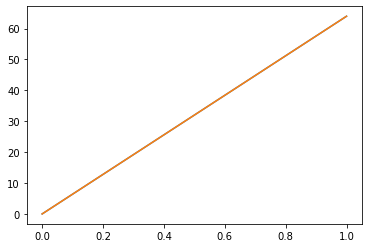

In [17]:
F_l_t = np.sum(F_to[:, bc_l_x.dofs], axis=-1)
F_r_t = np.sum(F_to[:, bc_r_x.dofs], axis=-1)
U_r_t = np.average(U_to[:, bc_r_x.dofs], axis=-1)

import matplotlib.pylab as plt
plt.plot(-U_r_t, -F_r_t)
plt.plot(-U_r_t, F_l_t)